In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster,dendrogram,linkage
from scipy.cluster import hierarchy
import itertools

In [2]:
# Load iris dataset and seperate it to features and labels
iris = datasets.load_iris()
irisX = iris.data
irisY = iris.target

In [3]:
# Load breast cancer dataset and seperate it to features and labels
breastC = datasets.load_breast_cancer()
breastX = breastC.data
breastY = breastC.target

In [4]:
# Load optidigits dataset and seperate it to features and labels
optidigits = datasets.load_digits()
optidigitsX = optidigits.data
optidigitsY = optidigits.target

In [5]:
# Load yeast dataset and seperate it to features and labels
yeastTxt = open("yeast.data", "r")
yeastLines = yeastTxt.readlines()
firstData = []
trainData = []
lastData = []
for line in yeastLines:
    line = line.replace("\n", "")
    split = line.split("  ")
    firstData.append(split[0])
    lastData.append(split[-1])
    trainData.append([split[1], split[2], split[3], split[4], split[5], split[6], split[7], split[8]])
    
yeastFirst = np.asarray(firstData)
yeastX = np.asarray(trainData)
yeastLast = np.asarray(lastData)

In [6]:
# creating coassociation matrix 
def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
                
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')

In [8]:
def overall_quality(y,y_hat):
    return np.mean(y == y_hat) * 100 

In [7]:
# Class of Multi Evidence Accumulation Cluster which has different kind of clustering algorithm
# such as kmeans single link and average link methods
class multiEAC(BaseEstimator, ClusterMixin):
    def __init__(self, cut_threshold=0.5):
        self.cut_threshold = cut_threshold
        self.parameters = parameters
        self.parameters_SC = parameters_SC
        self.methods = ["single", "average"]
    def fit(self, X, y=None, method = None):
        
        for method in self.methods:
            coassociation_algorithms = []
            for i in self.parameters:
                coassociation_algorithms.append(create_coassociation_matrix(self._kmeans_clustering(X,i)))
                coassociation_algorithms.append(create_coassociation_matrix(self._singleLink_clustering(X,i)))
            for i in self.parameters_SC:
                coassociation_algorithms.append(create_coassociation_matrix(self._spectral_clustering(X, i)))

            C = sum(coassociation_algorithms)

            # get the average of the similarity mat
            avgC = np.divide(C.toarray(), (len(self.parameters)*2 + len(self.parameters_SC)))

            # flip the similarity. smaller value implies more similarity
            avgC = np.abs(np.max(avgC) - avgC)

            # build clusters
            self.Z_ = linkage(avgC, method = method)

            # Calculate the number of clusters using cluster lifetime from the dendrogram
            # The longest lifetime is choosen as number of cluster.
            self.dn = dendrogram(self.Z_, no_plot = True)
            distance_set = set()
            for i in self.dn['dcoord']:
                distance_set = distance_set.union(set(i))
            distances = list(distance_set)
            distances.sort(reverse=True)
            lifetime_dict = {}
            k = 2
            for i in range(len(distances)-1):
                lifetime_dict[k] = distances[i] - distances[i+1]
                k += 1
            self.n_clusters = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]
            self.labels_ = hierarchy.cut_tree(self.Z_, self.n_clusters).reshape(-1,)
        
        """
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        self.coassociation_matrix = coassociation_algorithms
        """
        return self

    def _kmeans_clustering(self, X, k):
        km = KMeans(n_clusters=k)
        return km.fit_predict(X)
    
    def _averageLink_clustering(self, X, k):
        alCluster = AgglomerativeClustering(n_clusters = k, linkage = "average")
        alCluster.fit(X)
        return alCluster.labels_
    
    def _singleLink_clustering(self, X, k):
        slCluster = AgglomerativeClustering(n_clusters = k, linkage = "single")
        slCluster.fit(X)
        return slCluster.labels_
    
    def _spectral_clustering(self, X, parameters):
        sc = SpectralClustering(n_clusters=parameters[0])
        return sc.fit_predict(X)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

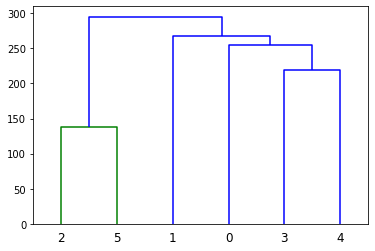

In [142]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = linkage(ytdist, 'single')
plt.figure()
dn = dendrogram(Z)
distance_set = set()
for i in dn['dcoord']:
    distance_set = distance_set.union(set(i))
distances = list(distance_set)
distances.sort(reverse=True)
lifetime_dict = {}
k = 2
for i in range(len(distances)-1):
    lifetime_dict[k] = distances[i] - distances[i+1]
    k += 1
lifetime_dict
k = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]
labels= fcluster(Z,t=k)
hierarchy.cut_tree(Z,k)

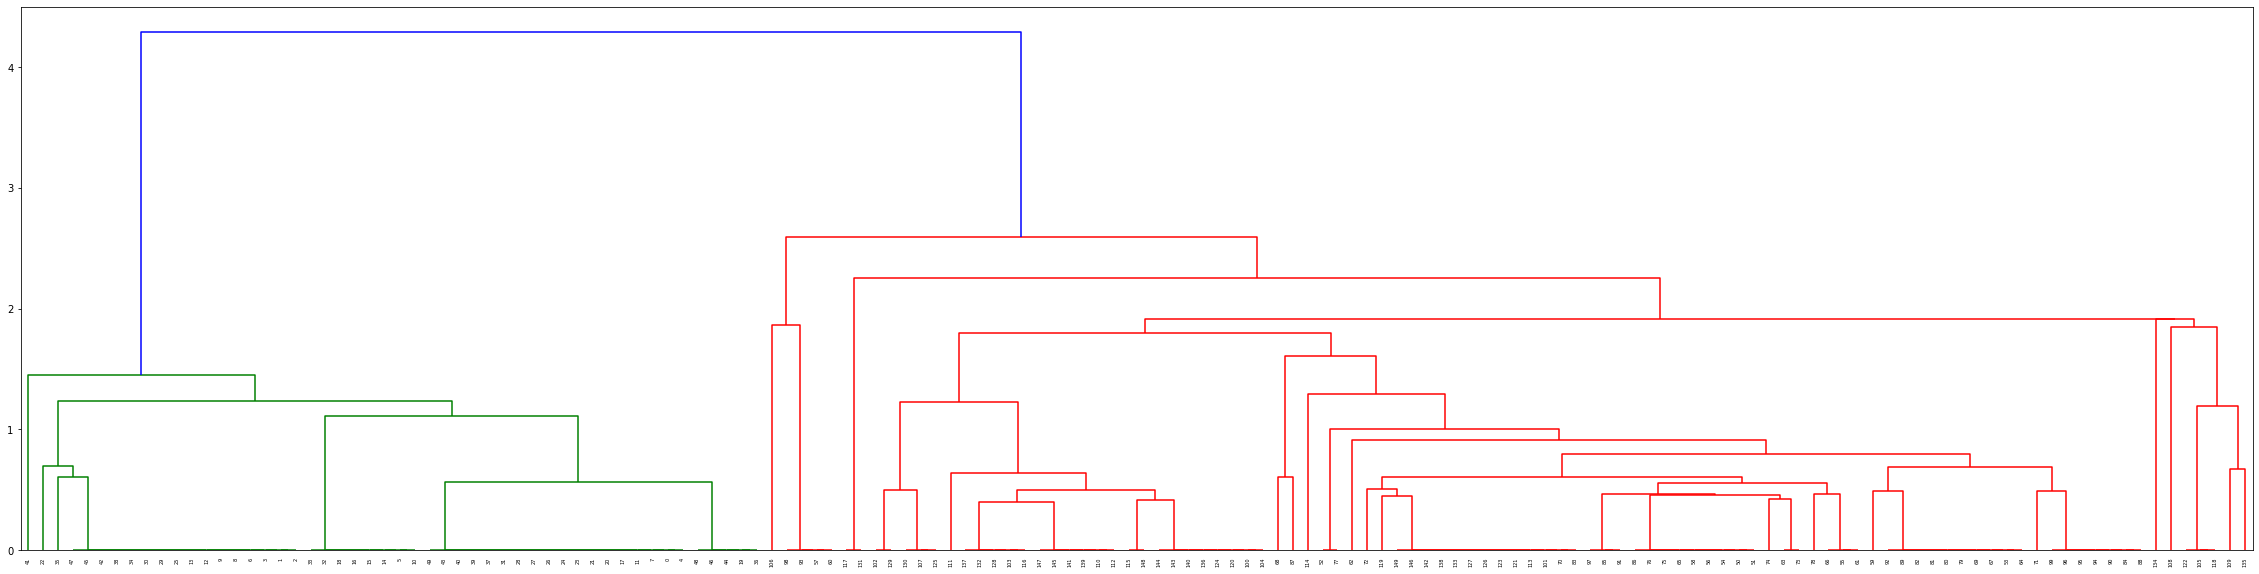

(150, 1)

In [138]:
eac1.Z_.shape
fig = plt.figure(figsize=(40, 10))
dn = dendrogram(eac1.Z_, get_leaves=True)
plt.show()
distance_set = set()
for i in dn['dcoord']:
    distance_set = distance_set.union(set(i))
distances = list(distance_set)
distances.sort(reverse=True)
lifetime_dict = {}
k = 2
for i in range(len(distances)-1):
    lifetime_dict[k] = distances[i] - distances[i+1]
    k += 1
lifetime_dict
k = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

In [141]:
hierarchy.cut_tree(eac1.Z_,3)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [164]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = []
eac1 = EAC(k, parameters_SC, cut_threshold=0.9)
eac1.fit(irisX)
print(overall_quality(irisY, (eac1.labels_-1)))
eac1.labels_-1

68.66666666666667


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [155]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = []
eac1 = EAC(k, parameters_SC, use_lifetime=True, cut_threshold=0.9)
eac1.fit(irisX)
print(overall_quality(irisY, (eac1.labels_)))
eac1.labels_

66.66666666666666


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [156]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = [(3,0.1), (12,0.1)]
eac2 = EAC(k, parameters_SC, cut_threshold=0.1)
eac2.fit(irisX)
print(overall_quality(irisY, (eac2.labels_ - 1)))
(eac2.labels_ - 1)

68.66666666666667


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [158]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = [(3,0.1), (12,0.1)]
eac2 = EAC(k, parameters_SC, use_lifetime=True, cut_threshold=0.1)
eac2.fit(irisX)
print(overall_quality(irisY, (eac2.labels_)))
(eac2.labels_)

66.66666666666666


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
# For Breast-C dataset
k = [2, 3, 5, 10]
parameters_SC = []
eac3 = EAC(k, parameters_SC, cut_threshold = 0.5)
eac3.fit(breasX)
print(overall_quality(breasY, np.abs(eac3.labels_ - 2)))
eac3.labels_
breasY

62.91739894551846


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,